## Empirical Asset pricing. 
### Testing the Fama/French 3-factor model.

Let's tests whether Fama French's 3-factor model holds out of sample. On Ken French's web page there is data posted on 100 portfolios formed on size and book-to-market (10x10). There is also data posted on the monthly F/F factors (SMB, HML, Rf, etc.). Use monthly data from 1993 to the present. For each portfolio, estimate loadings on the factors (use 5-year, monthly rolling betas - so past 60 observations). Then test whether the loadings explain the variation in returns across the 100 portfolios. Be careful in describing your test and standard error construction.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
RETURN = pd.read_csv('100_Portfolios_10x10.CSV').rename(columns={'Unnamed: 0':'yearmonth'})
RETURN = RETURN[RETURN['yearmonth'] > 199300]
RETURN.columns = RETURN.columns.str.replace(' ', '')
RETURN.head(3)

,yearmonth,SMALLLoBM,ME1BM2,ME1BM3,ME1BM4,ME1BM5,ME1BM6,ME1BM7,ME1BM8,ME1BM9,...,BIGLoBM,ME10BM2,ME10BM3,ME10BM4,ME10BM5,ME10BM6,ME10BM7,ME10BM8,ME10BM9,BIGHiBM
798,199301,5.0058,3.9575,6.5762,6.4824,9.0444,4.8421,8.3682,2.9728,8.1471,...,-3.8493,0.2863,1.9403,0.1493,-0.0866,1.9504,3.9954,3.1343,3.9508,13.4371
799,199302,-4.5362,-5.3163,-7.9586,-4.6689,-1.5136,1.0749,-1.0107,0.5561,-0.6979,...,-3.1497,-1.9138,2.2660,4.0238,4.8306,5.7410,5.3137,4.1839,3.2917,0.0650
800,199303,1.6287,0.2674,4.0697,3.7666,-1.6977,1.8126,6.5378,3.8956,4.3116,...,-0.1675,1.6531,3.8599,4.1025,2.6659,2.0636,-0.1267,0.8181,3.7613,5.5617


In [3]:
PORT_NAMES = list(RETURN.columns)
PORT_NAMES.remove('yearmonth')

In [4]:
FACTORS = pd.read_csv('North_America_3_Factors.csv').rename(columns={'Unnamed: 0':'yearmonth'})
FACTORS = FACTORS[FACTORS['yearmonth'] > 199300]
FACTORS.columns = FACTORS.columns.str.replace('-', '')
FACTORS.head(3)

,yearmonth,MktRF,SMB,HML,RF
30,199301,0.75,2.01,5.17,0.23
31,199302,0.45,-3.61,7.22,0.22
32,199303,2.34,0.60,1.98,0.25


In [5]:
DATA = RETURN.merge(FACTORS, on='yearmonth')

Use data from 1993-01 to 1997-12 as training data and data from 1998-01 to 2002-12 as testing data. Similarly, 2003 - 2007 data to train and 2008 - 2012 data to test; 2013 - 2017 data to train and 2018 - 2022 data to test.

In [6]:
def test_three_factors(train_start, train_end, test_start, test_end):
    train_start = train_start * 100
    train_end   = train_end   * 100
    test_start  = test_start  * 100
    test_end    = test_end    * 100

    DATA_TRAIN = DATA[(DATA['yearmonth'] > train_start) & (DATA['yearmonth'] < train_end)].copy()

    # returns of funds minus risk-free returns
    for name in PORT_NAMES : 
        DATA_TRAIN[name] = DATA_TRAIN[name] - DATA_TRAIN['RF']

    DATA_TEST = DATA[(DATA['yearmonth'] > test_start) & (DATA['yearmonth'] < test_end)].copy()


    for name in PORT_NAMES :

        reg_func = name + " ~ " + "MktRF + SMB + HML"
        model = smf.ols(reg_func, data=DATA_TRAIN)
        result = model.fit()

        DATA_TEST[name + "_beta_0"]     = result.params.Intercept
        DATA_TEST[name + "_beta_MktRF"] = result.params.MktRF
        DATA_TEST[name + "_beta_SMB"]   = result.params.SMB
        DATA_TEST[name + "_beta_HML"]   = result.params.HML 

        DATA_TEST[name + "_pred"] = DATA_TEST[name + "_beta_0"] + \
                                    DATA_TEST[name + "_beta_HML"] * DATA_TEST['HML'] + \
                                    DATA_TEST[name + "_beta_MktRF"] * DATA_TEST["MktRF"] + \
                                    DATA_TEST[name + "_beta_SMB"] * DATA_TEST["SMB"]

    AVER_PRED_RET = []
    AVER_RET = []
    RET = DATA_TEST.mean(axis=0)
    for name in PORT_NAMES :
        if RET[name] < -10:
            continue
        AVER_RET.append(RET[name])
        AVER_PRED_RET.append(RET[name + "_pred"])

    plt.scatter(AVER_PRED_RET, AVER_RET)
    plt.ylabel("real return")
    plt.xlabel("predicted return")
    plt.title("Testing 3 Factors Model")
    sns.regplot(y=AVER_RET, x=AVER_PRED_RET)

    slope, intercept, r_value, p_value, std_err = stats.linregress(AVER_PRED_RET, AVER_RET)


    return plt, p_value


The p_value of the predictability of 3 factor model is 0.0004783111090764899


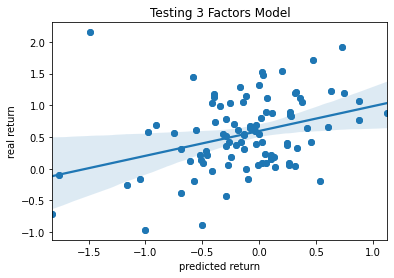

In [7]:
plot, p_value = test_three_factors(1993, 1998, 1998, 2003)

print('The p_value of the predictability of 3 factor model is', p_value)

The p_value of the predictability of 3 factor model is 0.0409735784204476


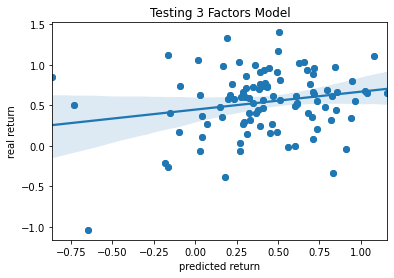

In [8]:
plot, p_value = test_three_factors(2003, 2008, 2008, 2013)

print('The p_value of the predictability of 3 factor model is', p_value)

The p_value of the predictability of 3 factor model is 0.321476196712177


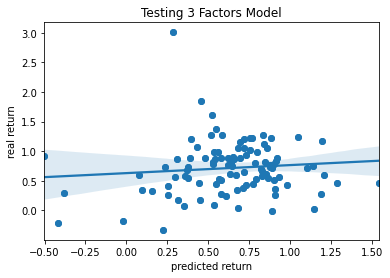

In [9]:
plot, p_value = test_three_factors(2013, 2018, 2018, 2023)

print('The p_value of the predictability of 3 factor model is', p_value)